## Model Selection
Testing, evaluating, and tuning a set of models to predict the number of bike rentals on each hour of the 20th day of each month. 

In [2]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn

from sklearn.model_selection import KFold, LeaveOneOut, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor


train = pd.read_csv("data/train_clean.csv", parse_dates = True)
test = pd.read_csv("data/test_clean.csv", parse_dates = True)

x_train = train.drop(["date","datetime","count"], axis=1)
y_train= train["count"]

x_test = test.drop(["datetime"], axis=1)

Applying 10-dold cross validation to estimate generalization error across several models and select a model algorithm. The loss funciton I've selected is mean squared error, becuase it it is fairly simple to interpret. 

In [3]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Machine': SVR()
}

kf = KFold(n_splits=10, random_state=24, shuffle=True)

results = []
for key in models.keys():
    # Perform cross-validation
    scores = cross_val_score(models[key], x_train, y_train, cv=kf, scoring="neg_mean_squared_error")

    new_results = {'model':key, 'mse': scores.mean()}
    results.append(new_results)



In [13]:
results

[{'model': 'Linear Regression', 'mse': -20101.94264938181},
 {'model': 'Decision Tree', 'mse': -3066.9951554313184},
 {'model': 'Random Forest', 'mse': -1547.0383541538715},
 {'model': 'Gradient Boosting', 'mse': -4108.382646258406},
 {'model': 'Support Vector Machine', 'mse': -30765.495013990603}]

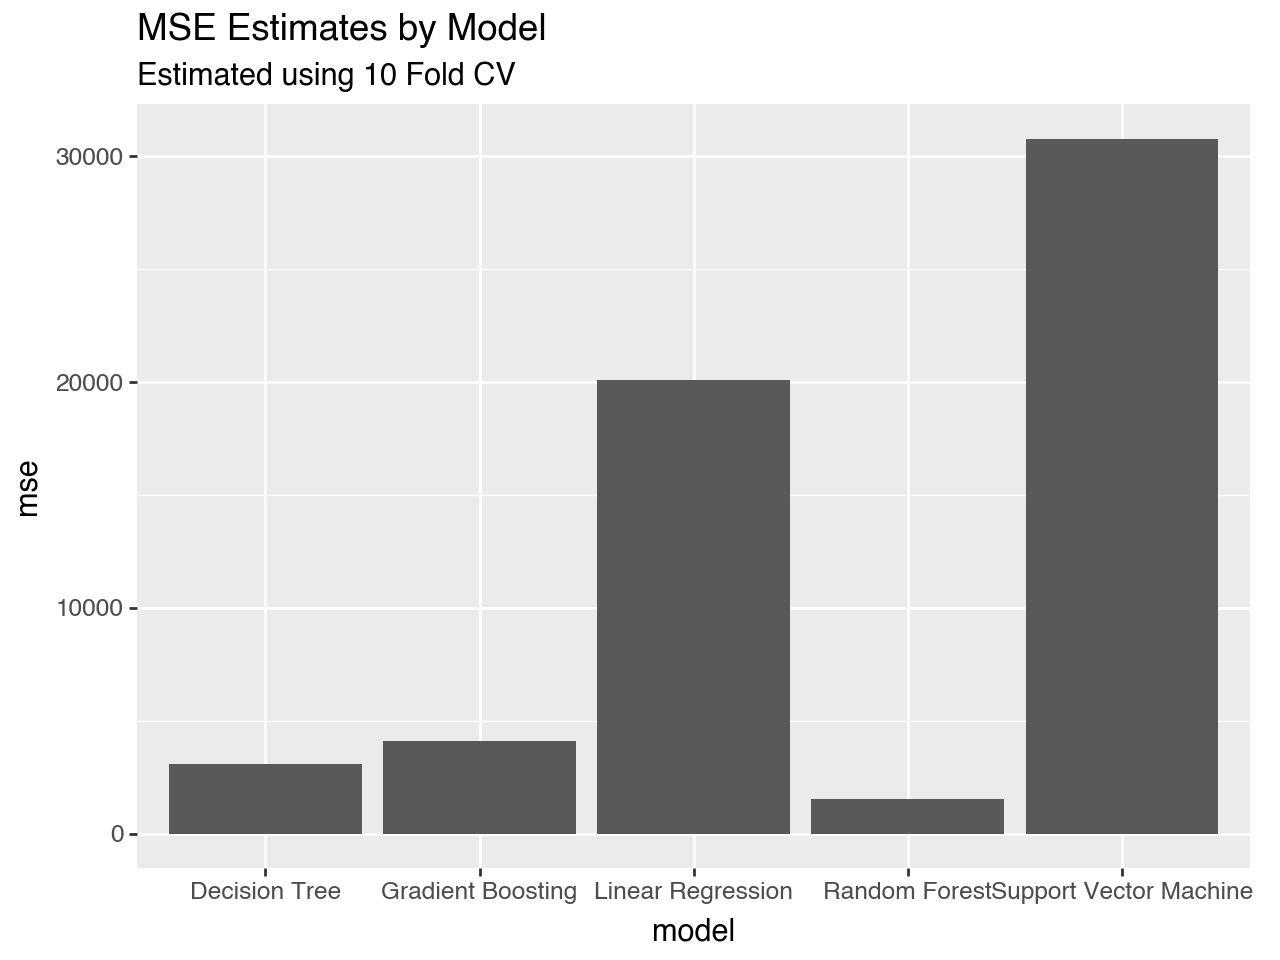

In [4]:
results_df = pd.DataFrame(results)
results_df["mse"] = results_df["mse"] *-1

(
    pn.ggplot(results_df, pn.aes("model","mse")) 
    + pn.geom_col() 
    + pn.labs(title="MSE Estimates by Model",
              subtitle="Estimated using 10 Fold CV")
)

Analysis: The random forset model outperformed the others by quite a bit, with an estimated generalization error of 1547. #ensemblemodelsrock. 

## Fitting the Model
The top performing model was a Random Forest. Now I will train the model using the entire training dataset. 

In [11]:
# training the model
model = RandomForestRegressor(random_state=24, oob_score=True)
model.fit(x_train, y_train)


RandomForestRegressor(oob_score=True, random_state=24)

In [ ]:
# making predictions for both datasets
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

## Diagnostics
Running a couple of basic diagnostic tests. 

In [12]:
# taking a look at the out of bag score as a gut check on this final model
print(f"OOB Score: {model.oob_score_}")

OOB Score: 0.9545129409498769


The OOB score, while using a different loss function than the one I used in model selection (MSE --> R-Squared), is an unbiased estimator for model performance without needing a validation set. 

Analysis: an R-squared OOB score of 0.95 is quite good! I feel fairly confident about the fit of the final model. 

In [10]:
# testing feature importance
importances = model.feature_importances_
features = x_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

         Feature  Importance
9           hour    0.589255
0     Unnamed: 0    0.182972
3     workingday    0.078935
6          atemp    0.032828
11   day_of_week    0.029263
7       humidity    0.025745
5           temp    0.022320
4        weather    0.013608
10  day_of_month    0.008082
14   day_of_year    0.007503
8      windspeed    0.005455
12         month    0.001759
2        holiday    0.001547
1         season    0.000655
13          year    0.000074


Analysis: there is some big variation in the importance scores of the included features. In future iterations I might see about identifying a less complex model. 

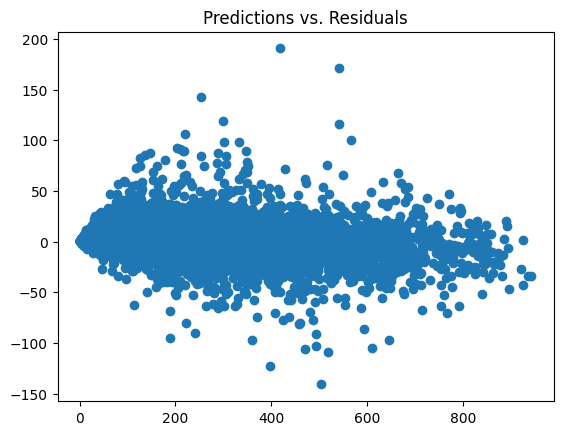

In [6]:
# checking residuals
train_residuals = train_predictions - y_train

plt.scatter(train_predictions, train_residuals)
plt.title("Predictions vs. Residuals")
plt.show()

Analysis: residuals appear fairly homoskedastic! Error is consistent across possible prediction values. 

## Final Results
Exporting the data submission. 

In [27]:
submission=pd.DataFrame({
    'datetime' : test['datetime'],
    'count' : test_predictions.astype('int')
})
submission.to_csv('data/submission.csv', index=False)

In [24]:
submission.reset_index(drop=True)

,datetime,count
0,2011-01-20 00:00:00,13
1,2011-01-20 01:00:00,6
2,2011-01-20 02:00:00,4
3,2011-01-20 03:00:00,3
4,2011-01-20 04:00:00,2
...,...,...
6488,2012-12-31 19:00:00,249
6489,2012-12-31 20:00:00,182
6490,2012-12-31 21:00:00,126
6491,2012-12-31 22:00:00,101
